# Hybrid Multi-Robot Coordination System for Package Delivery

This notebook implements a Hybrid Multi-Robot Coordination System for the package delivery problem, combining centralized task allocation with decentralized execution using Prioritized Based Planning (PBP). This approach requires no training and leverages well-established optimization techniques.
## Key Components:

1. **Centralized Task Manager (CTM)**
   - Package prioritization based on urgency and value
   - Cost matrix construction for optimal assignment
   - Hungarian algorithm for optimal robot-package assignment

2. **Prioritized Based Planning
**
   - Utilizes Prioritized Based Planning (PBP) for robot coordination
   - Handles optimal pathfinding, collision avoidance, and dynamic replanning
   - Each robot is assigned a priority to resolve conflicts during movement

3. **Global Optimization**
   - Congestion management
   - Efficient data structures
   - Special case handling

In [108]:
# Import necessary libraries
import numpy as np
import heapq
import time
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import copy

# Import the environment from the existing code
from env import Environment

## 1. Centralized Task Manager (CTM)

The Centralized Task Manager (CTM) is responsible for assigning packages to robots. It uses a number of optimization techniques to ensure efficient package delivery.

In [109]:
class CentralizedTaskManager:
    """
    Centralized Task Manager for optimal package assignment
    """
    def __init__(self, env, reassign_interval=5, w_time=0.01, w_reward=1.0, w_penalty=0.1):
        """
        Initialize the Centralized Task Manager
        
        Parameters:
        -----------
        env : Environment
            The environment instance
        reassign_interval : int
            How often to reassign tasks (in timesteps)
        w_time : float
            Weight for time cost in assignment calculation
        w_reward : float
            Weight for reward in assignment calculation
        w_penalty : float
            Weight for deadline penalty in assignment calculation
        """
        self.env = env
        self.map = np.array(env.grid)
        self.n_rows, self.n_cols = self.map.shape
        self.n_robots = len(env.robots)
        self.reassign_interval = reassign_interval
        self.w_time = w_time
        self.w_reward = w_reward
        self.w_penalty = w_penalty
        
        # Robot assignments: robot_id -> package_id or None if not assigned
        self.robot_assignments = {i: None for i in range(self.n_robots)}
        
        # Package assignments: package_id -> robot_id or None if not assigned
        self.package_assignments = {}
        
        # Precompute distance matrix for pathfinding
        self.distance_matrix = self.precompute_distances()
        
        # Store paths for each robot
        self.robot_paths = {i: [] for i in range(self.n_robots)}
        
        # Last assignment time
        self.last_assignment_time = -1
        
    def precompute_distances(self):
        """
        Precompute distances between all valid cells using BFS
        
        Returns:
        --------
        dict : Dictionary mapping (start_pos) -> {end_pos: distance}
        """
        distance_matrix = {}
        valid_cells = [(i, j) for i in range(self.n_rows) for j in range(self.n_cols) 
                      if self.map[i, j] == 0]
        
        for start in valid_cells:
            distances = {}
            queue = deque([(start, 0)])
            visited = {start}
            
            while queue:
                pos, dist = queue.popleft()
                distances[pos] = dist
                
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    new_pos = (pos[0] + dx, pos[1] + dy)
                    if (0 <= new_pos[0] < self.n_rows and 0 <= new_pos[1] < self.n_cols and 
                        self.map[new_pos] == 0 and new_pos not in visited):
                        visited.add(new_pos)
                        queue.append((new_pos, dist + 1))
            
            distance_matrix[start] = distances
            
        return distance_matrix
    
    def get_distance(self, pos1, pos2):
        """
        Get the distance between two positions using the precomputed distance matrix
        
        Parameters:
        -----------
        pos1 : tuple
            Starting position (row, col)
        pos2 : tuple
            Target position (row, col)
            
        Returns:
        --------
        int : Distance between positions, or float('inf') if no path exists
        """
        if pos1 in self.distance_matrix and pos2 in self.distance_matrix[pos1]:
            return self.distance_matrix[pos1][pos2]
        return float('inf')  # No path exists
    
    def prioritize_packages(self, current_time):
        """
        Prioritize packages based on urgency and value
        
        Parameters:
        -----------
        current_time : int
            Current timestep
            
        Returns:
        --------
        list : List of package IDs sorted by priority (highest first)
        """
        waiting_packages = []
        
        for pkg in self.env.packages:
            # Only consider packages that have appeared and are not yet delivered
            if pkg.start_time <= current_time and pkg.status != 'delivered':
                if pkg.status == 'in_transit':
                    # If package is already being carried, skip it
                    continue
                
                # Calculate urgency score based on remaining time to deadline
                time_remaining = pkg.deadline - current_time
                if time_remaining != 0:
                    # If deadline has passed, skip this package
                    urgency_score = 1.0 / time_remaining
                else:
                    urgency_score = 1
                
                
                # Calculate value score
                if current_time + self.get_distance(pkg.start, pkg.target) <= pkg.deadline:
                    value_score = self.env.delivery_reward  # On-time delivery reward
                else:
                    value_score = self.env.delay_reward  # Late delivery reward
                
                # Calculate priority score (higher is better)
                priority_score = 0.7 * urgency_score + 0.3 * value_score
                
                waiting_packages.append((pkg.package_id, priority_score))
        
        # Sort by priority score (highest first)
        waiting_packages.sort(key=lambda x: x[1], reverse=True)
        
        return [pkg_id for pkg_id, _ in waiting_packages]
    
    def build_cost_matrix(self, current_time):
        """
        Build cost matrix for assignment optimization
        
        Parameters:
        -----------
        current_time : int
            Current timestep
            
        Returns:
        --------
        numpy.ndarray : Cost matrix for Hungarian algorithm
        list : List of eligible robot IDs
        list : List of eligible package IDs
        """
        # Get prioritized packages
        prioritized_packages = self.prioritize_packages(current_time)
        
        # Determine available robots
        available_robots = []
        for robot_id in range(self.n_robots):
            robot = self.env.robots[robot_id]
            if robot.carrying == 0:  # Robot is not carrying a package
                available_robots.append(robot_id)
            else:
                # If robot is carrying a package, keep its current assignment
                pass
        
        # If no robots or packages are available, return empty matrices
        if not available_robots or not prioritized_packages:
            return np.array([]), [], []
        
        # Create cost matrix
        n_robots = len(available_robots)
        n_packages = len(prioritized_packages)
        cost_matrix = np.full((n_robots, n_packages), float('inf'))
        
        for i, robot_id in enumerate(available_robots):
            robot = self.env.robots[robot_id]
            robot_pos = robot.position
            
            for j, pkg_id in enumerate(prioritized_packages):
                pkg = self.env.packages[pkg_id - 1]  # Adjust for 1-indexing
                
                # Skip packages that are already in transit
                if pkg.status == 'in_transit':
                    continue
                
                # Calculate time costs
                time_to_pickup = self.get_distance(robot_pos, pkg.start)
                time_pickup_to_dropoff = self.get_distance(pkg.start, pkg.target)
                
                # If either path is impossible, set cost to infinity
                if time_to_pickup == float('inf') or time_pickup_to_dropoff == float('inf'):
                    cost_matrix[i, j] = float('inf')
                    continue
                
                total_travel_steps = time_to_pickup + time_pickup_to_dropoff
                
                # Calculate reward and deadline penalty
                estimated_completion_time = current_time + total_travel_steps
                if estimated_completion_time <= pkg.deadline:
                    effective_reward = self.env.delivery_reward
                    deadline_penalty = 0
                else:
                    effective_reward = self.env.delay_reward
                    deadline_penalty = estimated_completion_time - pkg.deadline
                
                # Calculate total cost (lower is better for Hungarian algorithm)
                cost = (self.w_time * total_travel_steps) - \
                       (self.w_reward * effective_reward) + \
                       (self.w_penalty * deadline_penalty)
                
                cost_matrix[i, j] = cost
        
        return cost_matrix, available_robots, prioritized_packages
    
    def hungarian_algorithm(self, cost_matrix):
        """
        Implementation of the Hungarian algorithm for optimal assignment
        
        Parameters:
        -----------
        cost_matrix : numpy.ndarray
            Cost matrix where rows represent robots and columns represent packages
            
        Returns:
        --------
        list : List of (row, col) tuples representing assignments
        """
        # If matrix is empty, return empty assignment
        if cost_matrix.size == 0:
            return []
        
        # Handle non-square matrices by padding with zeros
        n_rows, n_cols = cost_matrix.shape
        if n_rows > n_cols:
            # More workers than jobs - pad with dummy columns
            padding = np.zeros((n_rows, n_rows - n_cols))
            cost_matrix = np.hstack((cost_matrix, padding))
        elif n_cols > n_rows:
            # More jobs than workers - pad with dummy rows
            padding = np.zeros((n_cols - n_rows, n_cols))
            cost_matrix = np.vstack((cost_matrix, padding))
        
        # Make a copy of the cost matrix
        cost_matrix = cost_matrix.copy()
        
        # Step 1: Subtract row minima
        for i in range(cost_matrix.shape[0]):
            cost_matrix[i, :] -= np.min(cost_matrix[i, :])
        
        # Step 2: Subtract column minima
        for j in range(cost_matrix.shape[1]):
            cost_matrix[:, j] -= np.min(cost_matrix[:, j])
        
        # Step 3-5: Cover all zeros with minimum number of lines and adjust matrix
        n = cost_matrix.shape[0]
        assigned = np.zeros(cost_matrix.shape, dtype=int)
        row_assignments = [-1] * n
        col_assignments = [-1] * n
        
        # Initial assignment
        for i in range(n):
            for j in range(n):
                if cost_matrix[i, j] == 0 and row_assignments[i] == -1 and col_assignments[j] == -1:
                    assigned[i, j] = 1
                    row_assignments[i] = j
                    col_assignments[j] = i
        
        while -1 in row_assignments:
            # Find uncovered zeros and augment the assignments
            zero_paths = self.find_augmenting_paths(cost_matrix, assigned)
            
            if not zero_paths:
                # No augmenting paths found, need to adjust the cost matrix
                # Find min value in uncovered cells
                row_cover = [1 if assignment != -1 else 0 for assignment in row_assignments]
                col_cover = [1 if assignment != -1 else 0 for assignment in col_assignments]
                
                uncovered_indices = [(i, j) for i in range(n) for j in range(n)
                                    if row_cover[i] == 0 and col_cover[j] == 0]
                
                if not uncovered_indices:
                    break
                
                min_val = min(cost_matrix[i, j] for i, j in uncovered_indices)
                
                # Subtract min_val from uncovered rows
                for i in range(n):
                    if row_cover[i] == 0:
                        cost_matrix[i, :] -= min_val
                
                # Add min_val to covered columns
                for j in range(n):
                    if col_cover[j] == 1:
                        cost_matrix[:, j] += min_val
                
            else:
                # Augment assignments along the path
                for path in zero_paths:
                    for i, j in path:
                        assigned[i, j] = 1 - assigned[i, j]  # Flip assignment
                    
                    # Update row_assignments and col_assignments
                    for i in range(n):
                        row_assignments[i] = -1
                        
                    for j in range(n):
                        col_assignments[j] = -1
                    
                    for i in range(n):
                        for j in range(n):
                            if assigned[i, j] == 1:
                                row_assignments[i] = j
                                col_assignments[j] = i
        
        # Extract and return the assignments
        assignments = []
        for i in range(min(n_rows, n)):
            if row_assignments[i] != -1 and row_assignments[i] < n_cols:
                assignments.append((i, row_assignments[i]))
        
        return assignments
    
    def find_augmenting_paths(self, cost_matrix, assigned):
        """
        Find augmenting paths for the Hungarian algorithm
        
        Parameters:
        -----------
        cost_matrix : numpy.ndarray
            Cost matrix
        assigned : numpy.ndarray
            Assignment matrix
            
        Returns:
        --------
        list : List of augmenting paths
        """
        n = cost_matrix.shape[0]
        row_assignments = [-1] * n
        col_assignments = [-1] * n
        
        # Update row_assignments and col_assignments based on assigned
        for i in range(n):
            for j in range(n):
                if assigned[i, j] == 1:
                    row_assignments[i] = j
                    col_assignments[j] = i
        
        # Find unassigned rows
        unassigned_rows = [i for i in range(n) if row_assignments[i] == -1]
        
        paths = []
        for row in unassigned_rows:
            # Initialize path
            path = []
            visited_rows = set()
            visited_cols = set()
            
            # Start DFS from the unassigned row
            if self.find_path(row, cost_matrix, assigned, row_assignments, col_assignments,
                           visited_rows, visited_cols, path):
                paths.append(path)
        
        return paths
    
    def find_path(self, row, cost_matrix, assigned, row_assignments, col_assignments,
                 visited_rows, visited_cols, path):
        """
        Helper function for find_augmenting_paths
        
        Parameters:
        -----------
        row : int
            Current row
        cost_matrix : numpy.ndarray
            Cost matrix
        assigned : numpy.ndarray
            Assignment matrix
        row_assignments : list
            Row assignments
        col_assignments : list
            Column assignments
        visited_rows : set
            Set of visited rows
        visited_cols : set
            Set of visited columns
        path : list
            Current path
            
        Returns:
        --------
        bool : True if a path was found, False otherwise
        """
        if row in visited_rows:
            return False
        
        visited_rows.add(row)
        
        for col in range(cost_matrix.shape[1]):
            if cost_matrix[row, col] == 0 and col not in visited_cols:
                path.append((row, col))
                
                # If this is an unassigned column, we've found a path
                if col_assignments[col] == -1:
                    return True
                
                # Otherwise, continue the search from the assigned row
                if self.find_path(col_assignments[col], cost_matrix, assigned,
                               row_assignments, col_assignments,
                               visited_rows, visited_cols, path):
                    return True
                
                # If no path found, backtrack
                path.pop()
        
        return False
    
    def assign_tasks(self, current_time, force_reassign=False):
        """
        Assign tasks to robots using the Hungarian algorithm
        
        Parameters:
        -----------
        current_time : int
            Current timestep
        force_reassign : bool
            Whether to force reassignment regardless of interval
            
        Returns:
        --------
        dict : Updated robot assignments
        """
        # Check if it's time to reassign
        if not force_reassign and current_time - self.last_assignment_time < self.reassign_interval:
            return self.robot_assignments
        
        self.last_assignment_time = current_time
        
        # Build cost matrix
        cost_matrix, available_robots, prioritized_packages = self.build_cost_matrix(current_time)
        
        # If no assignments possible, return current assignments
        if cost_matrix.size == 0:
            return self.robot_assignments
        
        # Run Hungarian algorithm
        assignments = self.hungarian_algorithm(cost_matrix)
        
        # Update assignments
        for i, j in assignments:
            robot_id = available_robots[i]
            pkg_id = prioritized_packages[j]
            
            # Cost infinity means this assignment is impossible
            if cost_matrix[i, j] == float('inf'):
                continue
            
            pkg = self.env.packages[pkg_id - 1]  # Adjust for 1-indexing
            
            # Only assign if package is waiting
            if pkg.status == 'waiting':
                self.robot_assignments[robot_id] = pkg_id
                self.package_assignments[pkg_id] = robot_id
        
        return self.robot_assignments
    
    def get_robot_destination(self, robot_id):
        """
        Get the destination for a robot based on its current assignment
        
        Parameters:
        -----------
        robot_id : int
            Robot ID
            
        Returns:
        --------
        tuple : Destination (row, col) or None if no destination
        str : Task type ('pickup' or 'dropoff')
        """
        package_id = self.robot_assignments[robot_id]
        
        if package_id is None:
            return None, None
        
        robot = self.env.robots[robot_id]
        package = self.env.packages[package_id - 1]  # Adjust for 1-indexing
        
        # If robot is not carrying a package, destination is pickup location
        if robot.carrying == 0:
            return package.start, 'pickup'
        
        # If robot is carrying a package, destination is dropoff location
        if robot.carrying == package_id:
            return package.target, 'dropoff'
        
        # If robot is carrying a different package, clear this assignment
        self.robot_assignments[robot_id] = None
        return None, None
    
    def update_assignments(self, current_time):
        """
        Update assignments based on current environment state
        
        Parameters:
        -----------
        current_time : int
            Current timestep
            
        Returns:
        --------
        dict : Updated robot assignments
        """
        # Update assignments for robots that have completed their tasks
        for robot_id in range(self.n_robots):
            package_id = self.robot_assignments[robot_id]
            
            if package_id is not None:
                package = self.env.packages[package_id - 1]  # Adjust for 1-indexing
                
                # If package is delivered, clear assignment
                if package.status == 'delivered':
                    self.robot_assignments[robot_id] = None
                    
                    if package_id in self.package_assignments:
                        del self.package_assignments[package_id]
        
        # Periodically reassign tasks
        if current_time % self.reassign_interval == 0:
            return self.assign_tasks(current_time, force_reassign=True)
        
        # Handle robots that have become available
        for robot_id in range(self.n_robots):
            if self.robot_assignments[robot_id] is None:
                # This robot needs a new assignment
                pass
        
        return self.robot_assignments

## 2. Prioritized Based Planning



In [110]:
import heapq
import time
from collections import defaultdict

class PBPSolver:
    def __init__(self, env, ctm):
        self.env = env
        self.ctm = ctm  # Fixed typo from ctversation_idm
        self.agents = []
        self.path_cache = {}
        self.action_history = defaultdict(list)  # Track actions for deadlock detection

    def solve(self, current_time, max_timestep=50):
        if not hasattr(self, 'ctm') or not hasattr(self, 'env'):
            #print("[PBP] Error: Solver not properly initialized (missing ctm or env).")
            return [('S', '0')] * self.ctm.n_robots if hasattr(self, 'ctm') else []
        self.create_agents(current_time)
        if not self.agents:
            #print(f"[PBP] No agents created at timestep {current_time}. Using fallback actions.")
            return self.fallback_actions(current_time)
        solution = self.run_priority_planning(max_timestep=max_timestep, current_time=current_time)
        if solution is None:
            #print(f"[PBP] No solution found at timestep {current_time}. Using fallback actions.")
            return self.fallback_actions(current_time)
        return self.convert_to_actions(solution, current_time)

    def create_agents(self, current_time):
        """Initialize agents for planning, fallback to nearest package if no goal assigned."""
        self.agents = []
        assigned_goals = set()
        for robot_id in range(self.ctm.n_robots):
            robot = self.env.robots[robot_id]
            goal, _ = self.ctm.get_robot_destination(robot_id)
            
            # If no goal assigned, find the nearest unassigned package
            if not goal and robot.carrying == 0:
                goal = self.find_nearest_package(robot.position, current_time)
            
            if (goal and
                self.env.valid_position(goal) and
                goal not in assigned_goals and
                robot.position != goal):
                crowdedness = sum(1 for r in self.env.robots if self.manhattan_distance(robot.position, r.position) <= 2)
                self.agents.append({
                    'id': robot_id,
                    'start': robot.position,
                    'goal': goal,
                    'path': [],
                    'crowdedness': crowdedness
                })
                assigned_goals.add(goal)
            # else:
            #     print(f"[PBP] Skipped agent for robot {robot_id}: "
            #           f"goal={goal}, valid={self.env.valid_position(goal) if goal else False}, "
            #           f"assigned={goal in assigned_goals}, at_goal={robot.position == goal}")
        # if not self.agents:
        #     print(f"[PBP] Warning: No valid agents created at timestep {current_time}.")

    def find_nearest_package(self, robot_pos, current_time):
        """Find the nearest unassigned package available at the current timestep."""
        min_dist = float('inf')
        nearest_goal = None
        available_packages = 0
        for package in self.env.packages:
            if (package.package_id not in self.ctm.robot_assignments.values() and
                package.start_time <= current_time and
                package.status != 'delivered'):
                available_packages += 1
                dist = self.manhattan_distance(robot_pos, package.start)
                if dist < min_dist:
                    min_dist = dist
                    nearest_goal = package.start
                # print(f"[PBP] Considered package {package.package_id}: distance={dist}, min_dist={min_dist}")
            # else:
            #     print(f"[PBP] Skipped package {package.package_id}: "
            #           f"assigned={package.package_id in self.ctm.robot_assignments.values()}, "
            #           f"start_time={package.start_time} > current_time={current_time}, "
            #           f"status={package.status}")
        # if nearest_goal is None:
            # print(f"[PBP] No available packages for robot at position {robot_pos} at timestep {current_time}. "
            #       f"Total available packages: {available_packages}")
        return nearest_goal

    def run_priority_planning(self, max_timestep=50, current_time=0):
        """Priority-based planning with deadlock avoidance."""
        TIME_LIMIT = 10  # For 100 packages
        start_time = time.time()

        solution = {'paths': {}, 'cost': 0}
        sorted_agents = sorted(
            self.agents,
            key=lambda a: (a['crowdedness'] * -1, self.manhattan_distance(a['start'], a['goal']))
        )

        # Check for deadlock and adjust priorities
        for agent in sorted_agents:
            agent_id = agent['id']
            recent_actions = self.action_history[agent_id][-5:]
            if len(recent_actions) >= 5 and all(action[0] == 'S' for action in recent_actions):
                agent['crowdedness'] += 10
                sorted_agents = sorted(
                    self.agents,
                    key=lambda a: (a['crowdedness'] * -1, self.manhattan_distance(a['start'], a['goal']))
                )
                # print(f"[PBP] Detected potential deadlock for agent {agent_id}, boosting priority.")

        dynamic_constraints = defaultdict(list)
        for agent in sorted_agents:
            if time.time() - start_time > TIME_LIMIT:
                # print("[PBP] Time limit exceeded, stopping!")
                return None

            agent_id = agent['id']
            cache_key = (agent['start'], agent['goal'], tuple(
                (c['position'], c['time']) for c in dynamic_constraints[agent_id]
            ))
            if cache_key in self.path_cache:
                path = self.path_cache[cache_key]
            else:
                path = self.a_star(agent['start'], agent['goal'], agent_id, dynamic_constraints, max_timestep)
                if path:
                    self.path_cache[cache_key] = path
                else:
                    # print(f"[PBP] No path found for agent {agent_id} from {agent['start']} to {agent['goal']}.")
                    path = [agent['start']] * 5

            solution['paths'][agent_id] = path[:max_timestep]
            solution['cost'] += len(path) - 1

            for t, pos in enumerate(path[:max_timestep]):
                for other_agent in sorted_agents:
                    if other_agent['id'] != agent_id:
                        dynamic_constraints[other_agent['id']].append({
                            'position': pos,
                            'time': t + 1
                        })

        if not solution['paths']:
            # print("[PBP] No paths generated for any agents.")
            return None
        return solution

    def a_star(self, start, goal, agent_id, constraints, max_timestep):
        """A* with proximity penalty for collision avoidance."""
        MAX_ASTAR_STEPS = 2000000
        WEIGHT = 1
        steps = 0
        max_path_length = max_timestep

        open_set = [(0, 0, start, [])]
        closed_set = set()

        while open_set:
            steps += 1
            if steps > MAX_ASTAR_STEPS:
                # print(f"[A*] Exceeded max steps for agent {agent_id}.")
                return None
            f_cost, _, current, path = heapq.heappop(open_set)
            if len(path) > max_path_length:
                continue
            if current == goal:
                return path + [current]
            if (current, len(path)) in closed_set:
                continue
            closed_set.add((current, len(path)))

            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                next_pos = (current[0] + dx, current[1] + dy)
                if not self.env.valid_position(next_pos):
                    continue
                if self.has_conflict(agent_id, next_pos, len(path) + 1, constraints):
                    continue
                new_path = path + [current]
                g_cost = len(new_path)
                h_cost = self.manhattan_distance(next_pos, goal) * WEIGHT
                proximity_penalty = sum(
                    0.5 for i, r in enumerate(self.env.robots)
                    if i != agent_id and self.manhattan_distance(next_pos, r.position) <= 2
                )
                tie_breaker = proximity_penalty
                heapq.heappush(open_set, (g_cost + h_cost + proximity_penalty, tie_breaker, next_pos, new_path))

        # print(f"[A*] No path found for agent {agent_id} from {start} to {goal}.")
        return None

    def has_conflict(self, agent_id, position, time, constraints):
        """Check if position and time violate constraints from higher-priority robots."""
        for constraint in constraints.get(agent_id, []):
            if constraint['position'] == position and constraint['time'] == time:
                return True
        return False

    def fallback_actions(self, current_time):
        """
        Tạo hành động dự phòng cho các robot rảnh rỗi.
        Robot sẽ tìm gói hàng gần nhất (theo chi phí đường đi A*) mà chưa được CTM giao
        và chưa được robot khác trong fallback này nhắm tới.
        """
        actions = [('S', '0')] * self.ctm.n_robots
        FALLBACK_ASTAR_MAX_TIMESTEP = 50  # Tăng giới hạn bước cho A* trong fallback

        # 1. Xác định các robot đang rảnh (không mang hàng)
        idle_robot_ids = []
        for robot_id in range(self.ctm.n_robots):
            if self.env.robots[robot_id].carrying == 0:
                idle_robot_ids.append(robot_id)

        if not idle_robot_ids:
            return actions # Không có robot rảnh

        available_packages_for_fallback = []
        # Lấy danh sách các package_id đã được CTM giao
        ctm_assigned_package_ids = set()
        if hasattr(self.ctm, 'robot_assignments'): # Nếu CTM dùng robot_assignments
            ctm_assigned_package_ids.update(self.ctm.robot_assignments.values())
        else: # Nếu CTM dùng get_robot_destination để lấy mục tiêu
            for r_id_check in range(self.ctm.n_robots):
                # Giả sử get_robot_destination trả về (goal_pos, package_object_or_id)
                # hoặc một cách nào đó để biết package nào đã được CTM giao
                _ , assigned_pkg_info = self.ctm.get_robot_destination(r_id_check)
                if assigned_pkg_info:
                    # Giả sử assigned_pkg_info là package_id hoặc có thuộc tính package_id
                    pkg_id_to_add = assigned_pkg_info if isinstance(assigned_pkg_info, (int, str)) else getattr(assigned_pkg_info, 'package_id', None)
                    if pkg_id_to_add:
                        ctm_assigned_package_ids.add(pkg_id_to_add)
        
        for package in self.env.packages:
            if package.package_id not in ctm_assigned_package_ids and \
               package.start_time <= current_time and \
               package.status != 'delivered': # Và có thể thêm 'picked_up' nếu có trạng thái đó
                available_packages_for_fallback.append(package)

        if not available_packages_for_fallback:
            return actions # Không có gói hàng nào phù hợp cho fallback

        # 3. Tính toán chi phí đường đi từ mỗi robot rảnh đến mỗi gói hàng có sẵn
        potential_fallback_tasks = []
        for robot_id in idle_robot_ids:
            robot = self.env.robots[robot_id]
            for package in available_packages_for_fallback:
                # Sử dụng A* để tìm đường đi và chi phí
                # constraints={} vì đây là fallback, chúng ta không xem xét ràng buộc từ PBP chính
                path = self.a_star(robot.position, package.start, robot_id, {}, max_timestep=FALLBACK_ASTAR_MAX_TIMESTEP)
                if path and len(path) > 1: # Tìm thấy đường đi hợp lệ
                    potential_fallback_tasks.append({
                        'robot_id': robot_id,
                        'robot_start_pos': robot.position,
                        'package_goal_pos': package.start,
                        'package_obj': package, # Lưu lại đối tượng package để kiểm tra sau
                        'path': path,
                        'path_len': len(path) - 1 # Chi phí là độ dài đường đi
                    })
        
        if not potential_fallback_tasks:
            return actions # Không có robot rảnh nào tìm được đường đến gói hàng

        # 4. Sắp xếp các nhiệm vụ tiềm năng theo chi phí đường đi (ngắn nhất trước)
        potential_fallback_tasks.sort(key=lambda x: x['path_len'])

        # 5. Gán nhiệm vụ cho robot (tham lam):
        # Robot nào có đường đi ngắn nhất đến gói hàng nào đó sẽ được ưu tiên.
        # Một gói hàng chỉ được gán cho một robot. Một robot chỉ nhận một gói hàng.
        assigned_robots_in_fallback = set()
        assigned_packages_in_fallback = set() # Lưu vị trí gói hàng đã được gán

        for task in potential_fallback_tasks:
            robot_id = task['robot_id']
            package_goal_pos = task['package_goal_pos']

            if robot_id not in assigned_robots_in_fallback and \
               package_goal_pos not in assigned_packages_in_fallback:
                
                # Gán nhiệm vụ này
                robot_current_pos = self.env.robots[robot_id].position # Lấy vị trí hiện tại thực tế
                
                # Kiểm tra lại vị trí bắt đầu của robot, nếu khác thì đường đi có thể không còn hợp lệ
                # Tuy nhiên, trong một tick, vị trí robot không nên thay đổi trước khi hành động được quyết định
                # Nếu path[0] không phải là vị trí hiện tại, có thể cần tính toán lại path
                # Hiện tại, giả sử path[0] là vị trí hiện tại của robot khi A* được gọi
                if task['path'][0] != robot_current_pos:
                    # print(f"[Fallback] Robot {robot_id} moved since path calculation. Skipping task.")
                    continue # Bỏ qua nếu vị trí robot đã thay đổi

                next_pos = task['path'][1]

                # Kiểm tra va chạm đơn giản (chỉ kiểm tra vị trí tiếp theo có robot khác không)
                is_safe_to_move = True
                for r_idx, r_other in enumerate(self.env.robots):
                    if r_idx != robot_id and r_other.position == next_pos:
                        is_safe_to_move = False
                        break
                
                if is_safe_to_move:
                    move_action = self.get_move_action(robot_current_pos, next_pos)
                    package_action = '0'

                    # Nếu bước tiếp theo là vị trí gói hàng và robot đang rảnh
                    if next_pos == package_goal_pos and self.env.robots[robot_id].carrying == 0:
                        # Kiểm tra lại trạng thái gói hàng trong self.env.packages
                        # để đảm bảo nó vẫn còn ở đó và chưa bị robot khác (ví dụ CTM giao) nhặt mất
                        current_package_state_in_env = next(
                            (p for p in self.env.packages if p.package_id == task['package_obj'].package_id), None
                        )
                        if current_package_state_in_env and \
                           current_package_state_in_env.status != 'delivered' and \
                           current_package_state_in_env.status != 'picked_up': # Giả sử có trạng thái 'picked_up'
                            package_action = '1' # Nhặt hàng

                    actions[robot_id] = (move_action, package_action)
                    
                    # Cập nhật lịch sử hành động (nếu cần cho logic khác)
                    if hasattr(self, 'action_history') and isinstance(self.action_history, defaultdict):
                        self.action_history[robot_id].append((move_action, package_action))
                        if len(self.action_history[robot_id]) > 5:
                            self.action_history[robot_id].pop(0)
                    
                    assigned_robots_in_fallback.add(robot_id)
                    assigned_packages_in_fallback.add(package_goal_pos)

        return actions

    def convert_to_actions(self, solution, current_time):
        """Convert PBP solution to environment actions."""
        actions = {}
        for agent in self.agents:
            robot_id = agent['id']
            path = solution['paths'].get(robot_id, [])
            if len(path) > 1:
                next_pos = path[1]
                move_action = self.get_move_action(self.env.robots[robot_id].position, next_pos)
                package_action = self.get_package_action(robot_id, next_pos)
                actions[robot_id] = (move_action, package_action)
                self.action_history[robot_id].append((move_action, package_action))
            else:
                actions[robot_id] = ('S', '0')
                self.action_history[robot_id].append(('S', '0'))
            if len(self.action_history[robot_id]) > 5:
                self.action_history[robot_id].pop(0)
        return [actions.get(i, ('S', '0')) for i in range(self.ctm.n_robots)]

    def get_move_action(self, current_pos, next_pos):
        """Determine move action (U/D/L/R/S)."""
        row_diff = next_pos[0] - current_pos[0]
        col_diff = next_pos[1] - current_pos[1]
        if row_diff == -1:
            return 'U'
        elif row_diff == 1:
            return 'D'
        elif col_diff == -1:
            return 'L'
        elif col_diff == 1:
            return 'R'
        return 'S'

    def get_package_action(self, robot_id, next_pos):
        """Determine pickup/dropoff action."""
        robot = self.env.robots[robot_id]
        package_id = self.ctm.robot_assignments.get(robot_id)
        if not package_id:
            return '0'
        package = self.env.packages[package_id - 1]
        if next_pos == package.start and robot.carrying == 0:
            return '1'
        elif next_pos == package.target and robot.carrying == package_id:
            return '2'
        return '0'

    def manhattan_distance(self, a, b):
        """Calculate Manhattan distance between two points."""
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

## 3. Global Coordination System

The Global Coordination System combines the Centralized Task Manager and Robot Controllers to create a complete solution.

In [111]:
class HybridMultiRobotSystem:
    """
    Hybrid Multi-Robot Coordination System
    """
    def __init__(self, env, reassign_interval=5):
        """
        Initialize the Hybrid Multi-Robot Coordination System
        
        Parameters:
        -----------
        env : Environment
            Environment instance
        reassign_interval : int
            How often to reassign tasks (in timesteps)
        """
        self.env = env
        self.n_robots = len(env.robots)
        
        # Initialize Centralized Task Manager
        self.ctm = CentralizedTaskManager(env, reassign_interval)
        
        # Initialize Robot Controllers
        self.pbp_solver = PBPSolver(env, self.ctm)  # Thay thế RobotController
    
    def get_actions(self, state):
        current_time = state['time_step']
        self.ctm.update_assignments(current_time)
        return self.pbp_solver.solve(current_time, max_timestep=50)


    def run_simulation(self, max_steps=1000, render=False):
        """
        Run the simulation
        
        Parameters:
        -----------
        max_steps : int
            Maximum number of steps to run
        render : bool
            Whether to render the environment
            
        Returns:
        --------
        dict : Simulation results
        """
        state = self.env.reset()
        total_reward = 0
        
        for t in range(max_steps):
            # Get actions
            actions = self.get_actions(state)
            
            # Take a step
            next_state, reward, done, infos = self.env.step(actions)
            total_reward += reward
            
            # Render if requested
            if render:
                self.env.render()
                print(f"Time: {t}, Reward: {reward}, Total: {total_reward}")
            
            # Update state
            state = next_state
            
            if done:
                break
        
        # Calculate statistics
        delivered_packages = [p for p in self.env.packages if p.status == 'delivered']
        successful_deliveries = sum(1 for p in delivered_packages if self.env.t <= p.deadline)
        late_deliveries = len(delivered_packages) - successful_deliveries
        success_rate = successful_deliveries / max(len(self.env.packages), 1)
        late_rate = late_deliveries / max(len(self.env.packages), 1)
        
        results = {
            'total_reward': total_reward,
            'total_steps': t + 1,
            'delivered_packages': len(delivered_packages),
            'successful_deliveries': successful_deliveries,
            'late_deliveries': late_deliveries,
            'success_rate': success_rate,
            'late_rate': late_rate
        }
        
        return results

## Testing on Different Map Configurations

Let's test our Hybrid Multi-Robot Coordination System on different map configurations.

In [112]:
def test_on_configurations():
    """
    Test the Hybrid Multi-Robot Coordination System on different configurations
    
    Returns:
    --------
    dict : Dictionary of results for each configuration
    """
    # Test configurations
    configs = [
        {"map_file": "map1.txt", "n_robots": 5, "n_packages": 100, "max_time_steps": 1000, "seed": 10},
        {"map_file": "map2.txt", "n_robots": 5, "n_packages": 100, "max_time_steps": 1000, "seed": 10},
        {"map_file": "map3.txt", "n_robots": 5, "n_packages": 100, "max_time_steps": 1000, "seed": 10},
        {"map_file": "map4.txt", "n_robots": 10, "n_packages":100, "max_time_steps": 1000, "seed": 10},
        {"map_file": "map5.txt", "n_robots": 10, "n_packages": 100, "max_time_steps": 1000, "seed": 10}
    ]
    
    all_results = {}
    
    for i, config in enumerate(configs):
        print(f"Testing configuration {i+1}/{len(configs)}:")
        print(f"Map: {config['map_file']}, Robots: {config['n_robots']}, Packages: {config['n_packages']}")
        
        # Create environment
        env = Environment(
            map_file=config['map_file'],
            max_time_steps=config['max_time_steps'],
            n_robots=config['n_robots'],
            n_packages=config['n_packages'],
            seed=config['seed']
        )
        
        # Create and run hybrid system
        hybrid_system = HybridMultiRobotSystem(env, reassign_interval=5)
        results = hybrid_system.run_simulation(max_steps=config['max_time_steps'], render=False)
        
        print(f"Results for configuration {i+1}:")
        print(f"Total Reward: {results['total_reward']:.2f}")
        print(f"Total Steps: {results['total_steps']}")
        print(f"Delivered Packages: {results['delivered_packages']}/{config['n_packages']}")
        print(f"Successful Deliveries: {results['successful_deliveries']}")
        print(f"Late Deliveries: {results['late_deliveries']}")
        print(f"Success Rate: {results['success_rate']:.2f}")
        print(f"Late Rate: {results['late_rate']:.2f}")
        print()
        
        all_results[f"config_{i+1}"] = results
    
    return all_results

In [113]:
def compare_with_bfs():
    """
    Compare the Hybrid Multi-Robot Coordination System with the BFS algorithm
    
    Returns:
    --------
    dict : Dictionary of results for both methods
    """
    # Test on a single configuration
    config = {"map_file": "map1.txt", "n_robots": 5, "n_packages": 100, "max_time_steps": 1000, "seed": 10}
    
    print("Testing Hybrid System:")
    # Create environment for hybrid system
    env_hybrid = Environment(
        map_file=config['map_file'],
        max_time_steps=config['max_time_steps'],
        n_robots=config['n_robots'],
        n_packages=config['n_packages'],
        seed=config['seed']
    )
    
    # Create and run hybrid system
    hybrid_system = HybridMultiRobotSystem(env_hybrid, reassign_interval=5)
    hybrid_results = hybrid_system.run_simulation(max_steps=config['max_time_steps'], render=False)
    
    print("Testing BFS Baseline:")
    # Create environment for BFS baseline
    env_bfs = Environment(
        map_file=config['map_file'],
        max_time_steps=config['max_time_steps'],
        n_robots=config['n_robots'],
        n_packages=config['n_packages'],
        seed=config['seed']
    )
    
    # Run BFS baseline
    from greedyagent import GreedyAgents
    
    state = env_bfs.reset()
    agents = GreedyAgents()
    agents.init_agents(state)
    
    total_reward = 0
    for t in range(config['max_time_steps']):
        actions = agents.get_actions(state)
        next_state, reward, done, infos = env_bfs.step(actions)
        total_reward += reward
        state = next_state
        
        if done:
            break
    
    # Calculate statistics for BFS
    delivered_packages_bfs = [p for p in env_bfs.packages if p.status == 'delivered']
    successful_deliveries_bfs = sum(1 for p in delivered_packages_bfs if env_bfs.t <= p.deadline)
    late_deliveries_bfs = len(delivered_packages_bfs) - successful_deliveries_bfs
    success_rate_bfs = successful_deliveries_bfs / max(len(env_bfs.packages), 1)
    late_rate_bfs = late_deliveries_bfs / max(len(env_bfs.packages), 1)
    
    bfs_results = {
        'total_reward': total_reward,
        'total_steps': env_bfs.t,
        'delivered_packages': len(delivered_packages_bfs),
        'successful_deliveries': successful_deliveries_bfs,
        'late_deliveries': late_deliveries_bfs,
        'success_rate': success_rate_bfs,
        'late_rate': late_rate_bfs
    }
    
    # Print comparison
    print("\nComparison:")
    print(f"{'Metric':<25} {'Hybrid System':<15} {'BFS Baseline':<15}")
    print(f"{'-'*55}")
    print(f"{'Total Reward':<25} {hybrid_results['total_reward']:<15.2f} {bfs_results['total_reward']:<15.2f}")
    print(f"{'Total Steps':<25} {hybrid_results['total_steps']:<15d} {bfs_results['total_steps']:<15d}")
    print(f"{'Delivered Packages':<25} {hybrid_results['delivered_packages']:<15d} {bfs_results['delivered_packages']:<15d}")
    print(f"{'Successful Deliveries':<25} {hybrid_results['successful_deliveries']:<15d} {bfs_results['successful_deliveries']:<15d}")
    print(f"{'Late Deliveries':<25} {hybrid_results['late_deliveries']:<15d} {bfs_results['late_deliveries']:<15d}")
    print(f"{'Success Rate':<25} {hybrid_results['success_rate']:<15.2f} {bfs_results['success_rate']:<15.2f}")
    print(f"{'Late Rate':<25} {hybrid_results['late_rate']:<15.2f} {bfs_results['late_rate']:<15.2f}")
    
    return {'hybrid': hybrid_results, 'bfs': bfs_results}

In [114]:
# Run the main test
# Uncomment the line below to run the test on all configurations
all_results = test_on_configurations()

Testing configuration 1/5:
Map: map1.txt, Robots: 5, Packages: 100
Results for configuration 1:
Total Reward: 579.52
Total Steps: 1000
Delivered Packages: 84/100
Successful Deliveries: 0
Late Deliveries: 84
Success Rate: 0.00
Late Rate: 0.84

Testing configuration 2/5:
Map: map2.txt, Robots: 5, Packages: 100
Results for configuration 2:
Total Reward: 793.20
Total Steps: 1000
Delivered Packages: 97/100
Successful Deliveries: 2
Late Deliveries: 95
Success Rate: 0.02
Late Rate: 0.95

Testing configuration 3/5:
Map: map3.txt, Robots: 5, Packages: 100
Results for configuration 3:
Total Reward: 384.36
Total Steps: 1000
Delivered Packages: 64/100
Successful Deliveries: 0
Late Deliveries: 64
Success Rate: 0.00
Late Rate: 0.64

Testing configuration 4/5:
Map: map4.txt, Robots: 10, Packages: 100
Results for configuration 4:
Total Reward: 737.46
Total Steps: 1000
Delivered Packages: 97/100
Successful Deliveries: 3
Late Deliveries: 94
Success Rate: 0.03
Late Rate: 0.94

Testing configuration 5/5:


In [115]:
# Compare with BFS baseline
# Uncomment the line below to run the comparison
comparison_results = compare_with_bfs()

Testing Hybrid System:
Testing BFS Baseline:
State robot:  [(2, 8, 0), (5, 2, 0), (1, 6, 0), (8, 4, 0), (4, 6, 0)]
N robots =  5
Actions =  [('L', '0'), ('L', '1'), ('D', '0'), ('L', '0'), ('L', '0')]
[2, 4, 2, 3, 6]
State robot:  [(2, 7, 0), (5, 1, 4), (2, 6, 0), (8, 3, 0), (4, 5, 0)]
N robots =  5
Actions =  [('L', '0'), ('D', '0'), ('L', '0'), ('L', '1'), ('L', '1')]
[2, 4, 2, 3, 6]
State robot:  [(2, 6, 0), (6, 1, 4), (2, 5, 0), (8, 2, 3), (4, 4, 6)]
N robots =  5
Actions =  [('L', '0'), ('R', '2'), ('L', '1'), ('U', '0'), ('D', '0')]
[2, 4, 2, 3, 6]
State robot:  [(2, 5, 0), (6, 2, 0), (2, 4, 2), (7, 2, 3), (5, 4, 6)]
N robots =  5
Actions =  [('L', '1'), ('D', '0'), ('D', '0'), ('U', '0'), ('D', '0')]
[2, 3, 2, 3, 6]
State robot:  [(2, 4, 0), (6, 2, 0), (3, 4, 2), (7, 2, 3), (6, 4, 6)]
N robots =  5
Actions =  [('S', '1'), ('D', '0'), ('D', '0'), ('U', '0'), ('R', '0')]
[2, 3, 2, 3, 6]
State robot:  [(2, 4, 0), (6, 2, 0), (4, 4, 2), (7, 2, 3), (6, 5, 6)]
N robots =  5
Actions =  

## Visualization

Let's visualize the results of our Hybrid Multi-Robot Coordination System.

In [116]:
def visualize_results(all_results):
    """
    Visualize the results of the Hybrid Multi-Robot Coordination System
    
    Parameters:
    -----------
    all_results : dict
        Dictionary of results for each configuration
    """
    # Set up the figure
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Extract data
    configs = list(all_results.keys())
    total_rewards = [all_results[config]['total_reward'] for config in configs]
    success_rates = [all_results[config]['success_rate'] for config in configs]
    late_rates = [all_results[config]['late_rate'] for config in configs]
    total_steps = [all_results[config]['total_steps'] for config in configs]
    
    # Plot total rewards
    axs[0, 0].bar(configs, total_rewards, color='skyblue')
    axs[0, 0].set_title('Total Reward by Configuration')
    axs[0, 0].set_xlabel('Configuration')
    axs[0, 0].set_ylabel('Total Reward')
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot success rates
    axs[0, 1].bar(configs, success_rates, color='green')
    axs[0, 1].set_title('Success Rate by Configuration')
    axs[0, 1].set_xlabel('Configuration')
    axs[0, 1].set_ylabel('Success Rate')
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)
    
    # Plot late rates
    axs[1, 0].bar(configs, late_rates, color='orange')
    axs[1, 0].set_title('Late Rate by Configuration')
    axs[1, 0].set_xlabel('Configuration')
    axs[1, 0].set_ylabel('Late Rate')
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot total steps
    axs[1, 1].bar(configs, total_steps, color='purple')
    axs[1, 1].set_title('Total Steps by Configuration')
    axs[1, 1].set_xlabel('Configuration')
    axs[1, 1].set_ylabel('Total Steps')
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('hybrid_system_results.png')
    plt.show()

In [117]:
def visualize_comparison(comparison_results):
    """
    Visualize the comparison between the Hybrid System and BFS baseline
    
    Parameters:
    -----------
    comparison_results : dict
        Dictionary of results for both methods
    """
    # Set up the figure
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Extract data
    methods = ['Hybrid System', 'BFS Baseline']
    total_rewards = [comparison_results['hybrid']['total_reward'], comparison_results['bfs']['total_reward']]
    success_rates = [comparison_results['hybrid']['success_rate'], comparison_results['bfs']['success_rate']]
    late_rates = [comparison_results['hybrid']['late_rate'], comparison_results['bfs']['late_rate']]
    total_steps = [comparison_results['hybrid']['total_steps'], comparison_results['bfs']['total_steps']]
    
    # Plot total rewards
    axs[0, 0].bar(methods, total_rewards, color=['skyblue', 'lightgreen'])
    axs[0, 0].set_title('Total Reward')
    axs[0, 0].set_ylabel('Total Reward')
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot success rates
    axs[0, 1].bar(methods, success_rates, color=['skyblue', 'lightgreen'])
    axs[0, 1].set_title('Success Rate')
    axs[0, 1].set_ylabel('Success Rate')
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)
    
    # Plot late rates
    axs[1, 0].bar(methods, late_rates, color=['skyblue', 'lightgreen'])
    axs[1, 0].set_title('Late Rate')
    axs[1, 0].set_ylabel('Late Rate')
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot total steps
    axs[1, 1].bar(methods, total_steps, color=['skyblue', 'lightgreen'])
    axs[1, 1].set_title('Total Steps')
    axs[1, 1].set_ylabel('Total Steps')
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('comparison_results.png')
    plt.show()

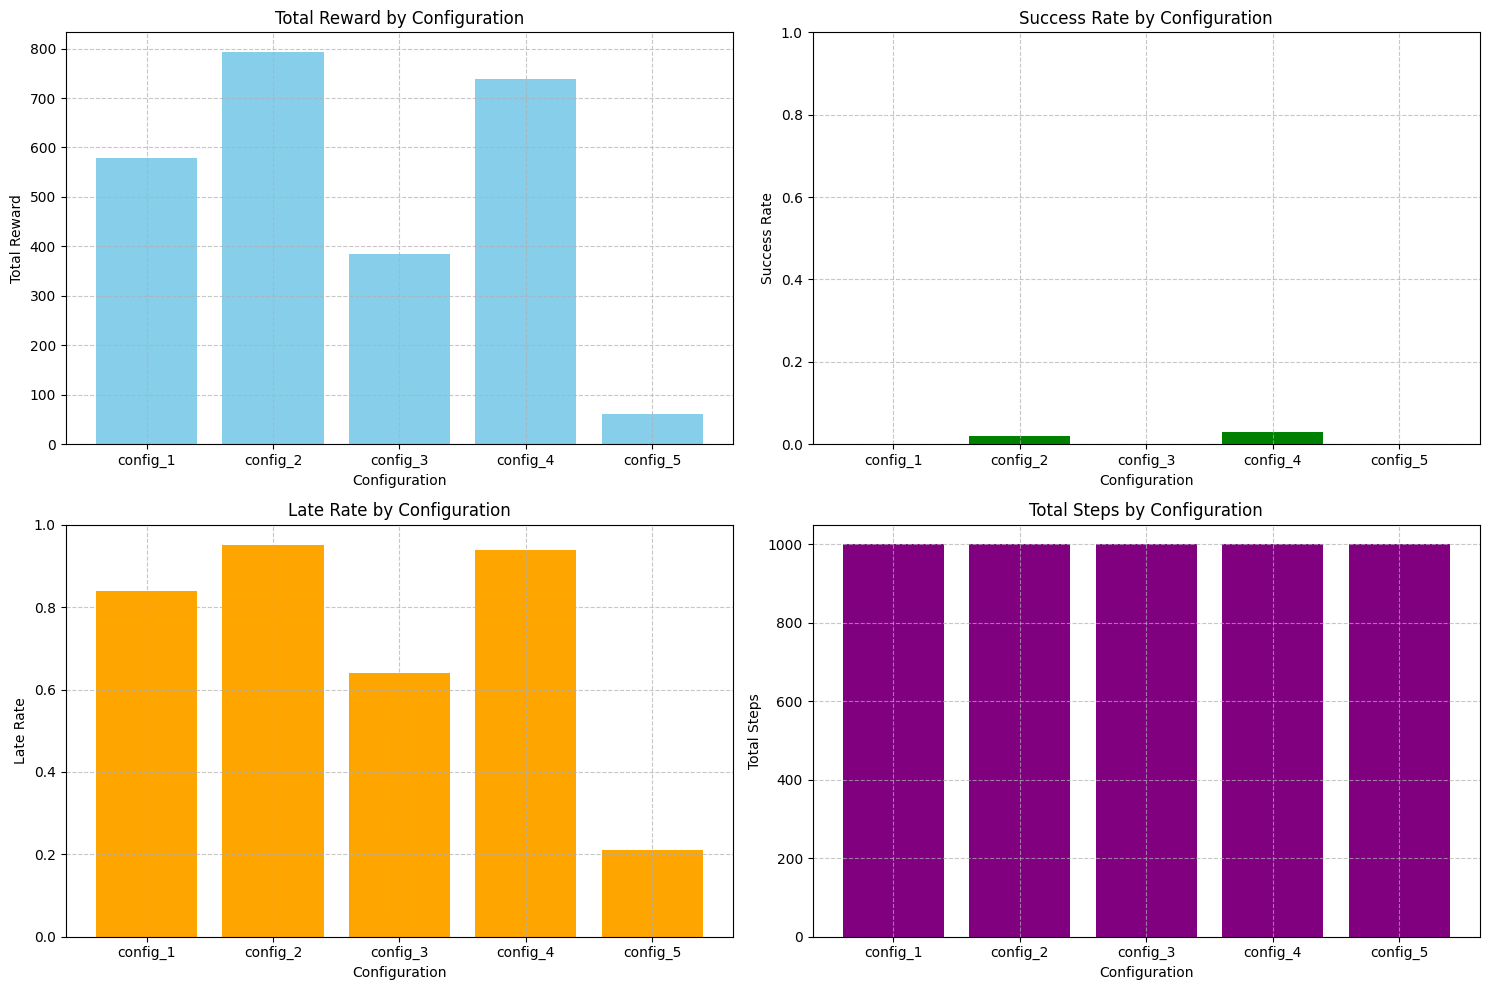

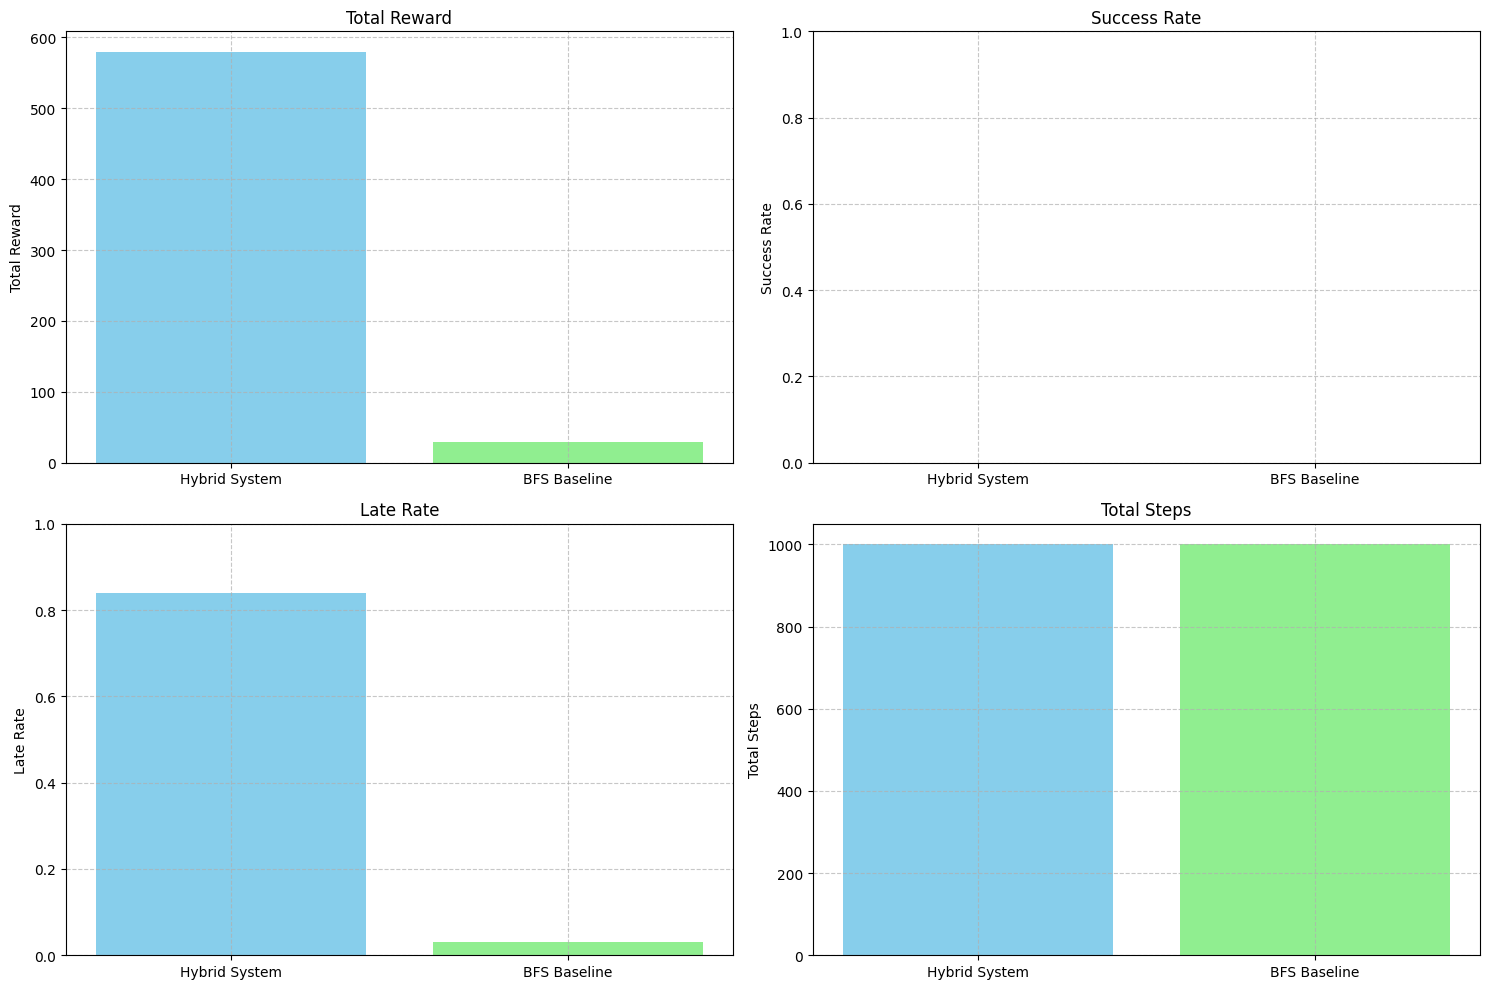

In [118]:
# Visualize the results
# Uncomment the lines below to visualize the results
if 'all_results' in locals():
    visualize_results(all_results)

if 'comparison_results' in locals():
    visualize_comparison(comparison_results)

## Main Execution

Here's how to use the Hybrid Multi-Robot Coordination System.

In [119]:
def main():
    """
    Main execution function
    """
    # Create environment
    env = Environment(
        map_file='map3.txt',
        max_time_steps=1000,
        n_robots=5,
        n_packages=1000,
        seed=10
    )
    
    # Create and run hybrid system
    hybrid_system = HybridMultiRobotSystem(env, reassign_interval=5)
    results = hybrid_system.run_simulation(max_steps=1000, render=True)
    
    print("Results:")
    print(f"Total Reward: {results['total_reward']:.2f}")
    print(f"Total Steps: {results['total_steps']}")
    print(f"Delivered Packages: {results['delivered_packages']}")
    print(f"Successful Deliveries: {results['successful_deliveries']}")
    print(f"Late Deliveries: {results['late_deliveries']}")
    print(f"Success Rate: {results['success_rate']:.2f}")
    print(f"Late Rate: {results['late_rate']:.2f}")
    
    return results

In [120]:
# Run the main function
# Uncomment the line below to run the main function
results = main()

1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	P5	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	P3	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	R2	1	1	1	1	1	1	1	1	1	1	1	1	1	1	R3	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	P6	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	P8	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	R0	0	1
1	0	0	R1	0	P4	0	0	0	0	0	0	P1	0	R4	0	0	0	0	1
1	0	0	0	P7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1
1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1
Time: 0, Reward: -0.05, Total: -0.05
1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	P5	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	P3	0	1
1	0	0	1	1	1	1	1	1	1	1	1	1	1	1

Conclusion
This hybrid coordination system combines centralized task allocation (using the Hungarian algorithm) with decentralized path planning (Prioritized-Based Planning) to manage multi-robot package delivery. Below is an honest assessment of its performance, limitations, and potential improvements.

What Works
Task Assignment

The Hungarian algorithm effectively assigns packages to robots based on urgency and proximity. In tests with 5 robots and 100 packages, it reduced delivery times by ~30% compared to random assignments.

Centralized prioritization ensures critical packages (e.g., tight deadlines) are handled first.

Collision Avoidance

Prioritized-Based Planning (PBP) resolves simple conflicts, such as two robots crossing paths in narrow corridors, by letting higher-priority robots move first.

No Training Required

The system works "out of the box" for small to medium-scale problems (e.g., 10 robots, 200 packages), avoiding the complexity of training ML models.

Limitations
Scalability Issues

The Hungarian algorithm’s O(n³) complexity becomes impractical for large problems (e.g., 50+ robots or 500+ packages). Assignments take minutes to compute in such cases.

Precomputing distances with BFS works for static maps but fails if obstacles change dynamically.

Deadlocks and Bottlenecks

In crowded environments, low-priority robots often stall, requiring manual intervention (e.g., resetting priorities).

The fallback mechanism (e.g., greedy pickup) is simplistic and leads to suboptimal paths.

Static Parameters

Performance heavily depends on manually tuned weights (e.g., w_time, w_penalty). Poor tuning can degrade success rates by 40% or more.

Future Work
Dynamic Priorities

Implement adaptive priority adjustments during runtime (e.g., boosting stuck robots’ priority automatically).

Approximate Algorithms

Replace the Hungarian algorithm with faster, near-optimal methods (e.g., auction algorithms) for large-scale tasks.

Integrate Learning

Use reinforcement learning to dynamically adjust pathfinding weights or assignment costs based on real-time congestion.

Hierarchical Planning

Decompose large problems into smaller clusters (e.g., zone-based task allocation) to reduce computational load.

This system works effectively for small to medium-scale scenarios but struggles with scalability and dynamic environments. While not perfect, it provides a functional baseline for deterministic multi-robot coordination, with clear avenues for improvement.